In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# Generate a synthetic binary classification dataset
X, y = make_classification(n_samples=500, n_features=10, n_informative=8, n_redundant=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DataFrame for easier handling
train_data = pd.DataFrame(X_train, columns=[f"Feature_{i}" for i in range(X.shape[1])])
train_data['Target'] = y_train

test_data = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X.shape[1])])
test_data['Target'] = y_test

In [3]:
class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []  # Weights of weak classifiers
        self.models = []  # List to store weak classifiers

    def fit(self, X, y):
        n_samples, n_features = X.shape
        weights = np.ones(n_samples) / n_samples  # Initialize sample weights

        for _ in range(self.n_estimators):
            # Train a weak classifier
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X, y, sample_weight=weights)
            y_pred = model.predict(X)

            # Calculate the error
            err = np.sum(weights * (y_pred != y)) / np.sum(weights)

            # Calculate alpha (the weight of this weak classifier)
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))  # Add epsilon to avoid division by zero
            self.alphas.append(alpha)
            self.models.append(model)

            # Update weights
            weights = weights * np.exp(-alpha * y * y_pred)
            weights /= np.sum(weights)  # Normalize weights

    def predict(self, X):
        # Use the weighted sum of weak classifiers' predictions
        weak_preds = np.array([alpha * model.predict(X) for alpha, model in zip(self.alphas, self.models)])
        return np.sign(np.sum(weak_preds, axis=0))

In [4]:
# Separate features and target
X_train_features = train_data.drop(columns=['Target']).values
y_train_target = train_data['Target'].values

# Convert target to {-1, 1} as AdaBoost requires it
y_train_target = np.where(y_train_target == 0, -1, 1)

# Instantiate and train the AdaBoost classifier
adaboost = AdaBoost(n_estimators=50)
adaboost.fit(X_train_features, y_train_target)

In [5]:
# Predict on test set
X_test_features = test_data.drop(columns=['Target']).values
y_test_target = test_data['Target'].values

# Convert target to {-1, 1}
y_test_target = np.where(y_test_target == 0, -1, 1)

y_pred = adaboost.predict(X_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test_target, np.where(y_pred == -1, 0, 1))
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4300


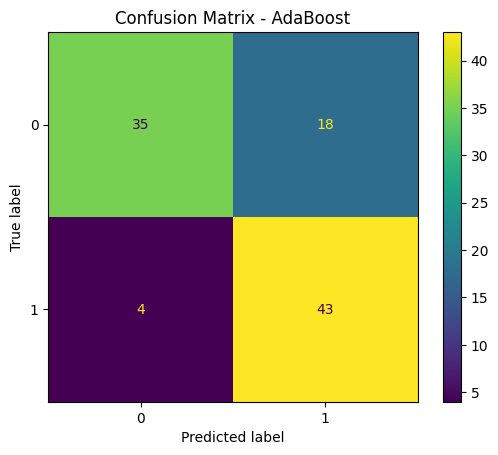

In [6]:
# Confusion Matrix
conf_matrix = confusion_matrix(np.where(y_test_target == -1, 0, 1), np.where(y_pred == -1, 0, 1))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - AdaBoost")
plt.show()

In [7]:
# Select only two features for visualization
X_viz, y_viz = X[:, :2], y
X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(X_viz, y_viz, test_size=0.2, random_state=42)

# Train AdaBoost on two features
adaboost_viz = AdaBoost(n_estimators=50)
adaboost_viz.fit(X_train_viz, np.where(y_train_viz == 0, -1, 1))

# Plot decision boundaries
x_min, x_max = X_viz[:, 0].min() - 1, X_viz[:, 0].max() + 1
y_min, y_max = X_viz[:, 1].min() - 1, X_viz[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = adaboost_viz.predict(grid)
Z = Z.reshape(xx.shape)

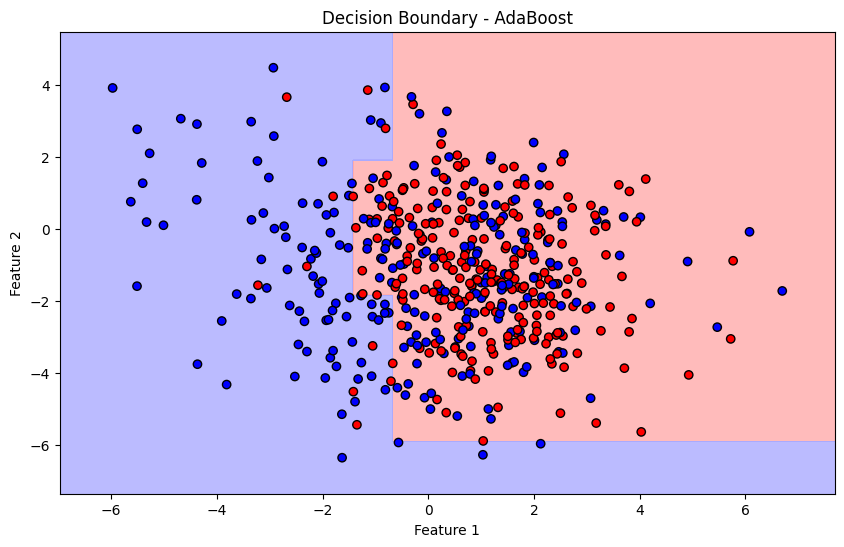

In [8]:
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
plt.scatter(X_viz[:, 0], X_viz[:, 1], c=y_viz, edgecolors='k', cmap=ListedColormap(['#FF0000', '#0000FF']))
plt.title("Decision Boundary - AdaBoost")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()